# EDA

Create your own EDA below/ Create as many code-blocks as you need.

Once you've completed your EDA, complete the section titled **Reflections** where you will answer questions about your EDA.

**Note**: Since this dataset is large, visualizations might load slower. You may want to consider using the `sample()` method if this dataset is too large for your computer to process in a reasonable amount of time.

In [1]:
import math

import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_columns = False

In [3]:
transactions = pd.read_csv("../data/bank_transactions.csv")

In [4]:
transactions.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,PAYMENT,983.09,C1454812978,36730.24,35747.15,M1491308340,0.00,0.00,0,0
1,PAYMENT,55215.25,C1031766358,99414.00,44198.75,M2102868029,0.00,0.00,0,0
2,CASH_IN,220986.01,C1451868666,7773074.97,7994060.98,C1339195526,924031.48,703045.48,0,0
3,TRANSFER,2357394.75,C458368123,0.00,0.00,C620979654,4202580.45,6559975.19,0,0
4,CASH_OUT,67990.14,C1098978063,0.00,0.00,C142246322,625317.04,693307.19,0,0


Certain transaction records exhibit inconsistencies in balance updates:

- **PAYMENT** transactions subtract the amount from the origin account (`oldbalanceOrg` to `newbalanceOrig`), while the destination balances remain unchanged. This pattern aligns with expectations.

- **CASH_IN** transactions increase the origin balance, but in some cases the destination balance decreases, which contradicts typical financial behavior. This may indicate issues with how the destination accounts were simulated.

- **TRANSFER** and **CASH_OUT** transactions sometimes show no change in the origin balance despite a significant amount being transferred. In contrast, the destination balances often reflect the received amount accurately.

In [5]:
((transactions['oldbalanceOrg'] - transactions['newbalanceOrig']) != transactions['amount']).sum()

930634

In [6]:
transactions.shape

(1000000, 10)

In [7]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   type            1000000 non-null  object 
 1   amount          1000000 non-null  float64
 2   nameOrig        1000000 non-null  object 
 3   oldbalanceOrg   1000000 non-null  float64
 4   newbalanceOrig  1000000 non-null  float64
 5   nameDest        1000000 non-null  object 
 6   oldbalanceDest  1000000 non-null  float64
 7   newbalanceDest  1000000 non-null  float64
 8   isFraud         1000000 non-null  int64  
 9   isFlaggedFraud  1000000 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 76.3+ MB


In [8]:
transactions.columns

Index(['type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [9]:
transactions.dtypes

type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [10]:
duplicates_number = transactions.duplicated().sum()
print(f'Number of duplicated rows in the dataset: {duplicates_number}')

Number of duplicated rows in the dataset: 0


### Categorical Features in the Dataset

The dataset contains the following categorical features:

- `type`: Specifies the type of transaction (e.g., PAYMENT, TRANSFER, etc.)
- `nameOrig`: Origin account name (should be dropped — not predictive)
- `nameDest`: Destination account name (should be dropped — not predictive)
- `isFlaggedFraud`: Output of a hard-coded fraud rule 
- `isFraud`: Binary label indicating actual fraud (target variable)

In [11]:
transactions['type'].value_counts()

type
CASH_OUT    351360
PAYMENT     338573
CASH_IN     219955
TRANSFER     83695
DEBIT         6417
Name: count, dtype: int64

In [12]:
transactions['type'].describe()

count      1000000
unique           5
top       CASH_OUT
freq        351360
Name: type, dtype: object

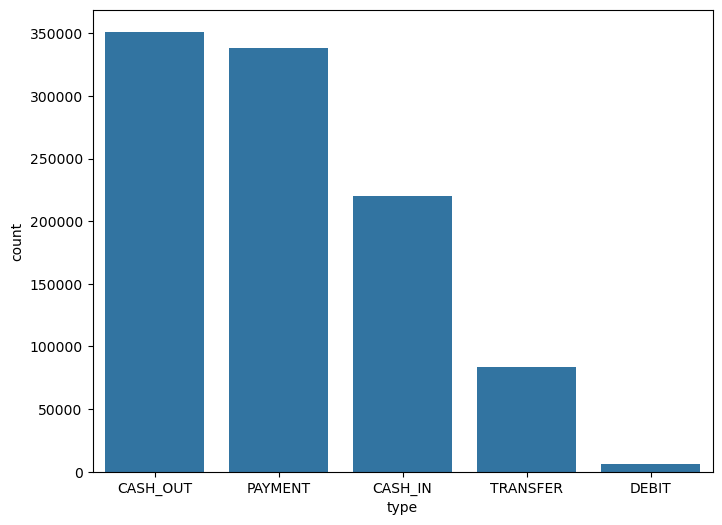

In [13]:
_, ax = plt.subplots(figsize=(8, 6))
sns.countplot(
    data=transactions,
    x='type',
    order=transactions['type'].value_counts().index,
    ax=ax
    )
plt.show()

In [14]:
transactions['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    999999
1         1
Name: count, dtype: int64

In [15]:
is_not_fraud, is_fraud = transactions['isFraud'].value_counts().to_list()
total = is_fraud + is_not_fraud
fraud_pct = is_fraud / total * 100
non_fraud_pct = is_not_fraud / total * 100

print(f'Number of non-fraud transactions: {is_not_fraud} ({non_fraud_pct:.2f}%)')
print(f'Number of fraud transactions:     {is_fraud} ({fraud_pct:.2f}%)')

Number of non-fraud transactions: 998703 (99.87%)
Number of fraud transactions:     1297 (0.13%)


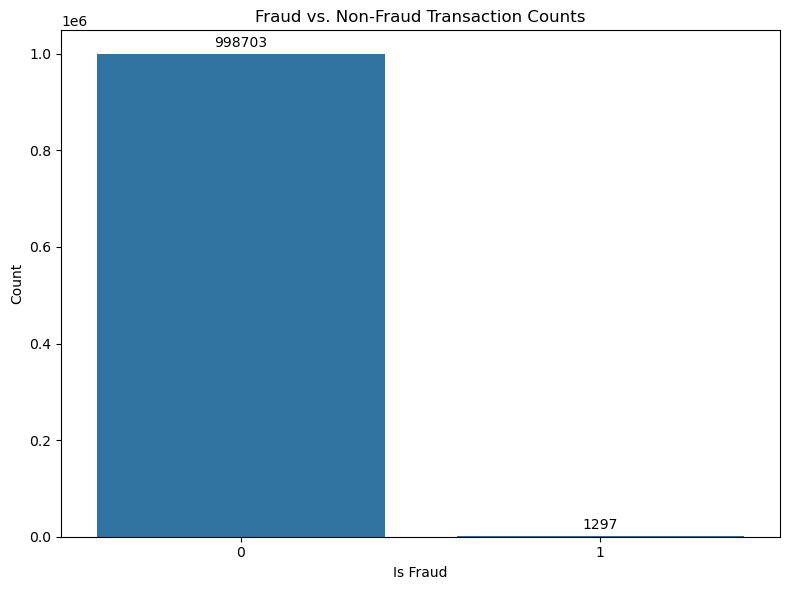

In [16]:
_, ax = plt.subplots(figsize=(8, 6))

sns.countplot(
    data=transactions, 
    x='isFraud', 
    ax=ax
    )

ax.set_title('Fraud vs. Non-Fraud Transaction Counts')
ax.set_xlabel('Is Fraud')
ax.set_ylabel('Count')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

plt.tight_layout()
plt.show()

The `isFraud` feature was intentionally **not used as a hue** in the main transaction type countplot. Fraudulent transactions represent only **0.13%** of the total, making their bars nearly invisible on a linear scale. While a log scale could address visibility, it would reduce interpretability. Instead, a **separate countplot** was created to clearly visualize the distribution of fraudulent and non-fraudulent transactions.

In [17]:
fraudulent_transactions = transactions[transactions['isFraud'] == 1]
non_fraudulent_transactions = transactions[transactions['isFraud'] == 0]

In [18]:
non_fraudulent_transactions['type'].value_counts()

type
CASH_OUT    350703
PAYMENT     338573
CASH_IN     219955
TRANSFER     83055
DEBIT         6417
Name: count, dtype: int64

In [19]:
fraudulent_transactions['type'].value_counts()

type
CASH_OUT    657
TRANSFER    640
Name: count, dtype: int64

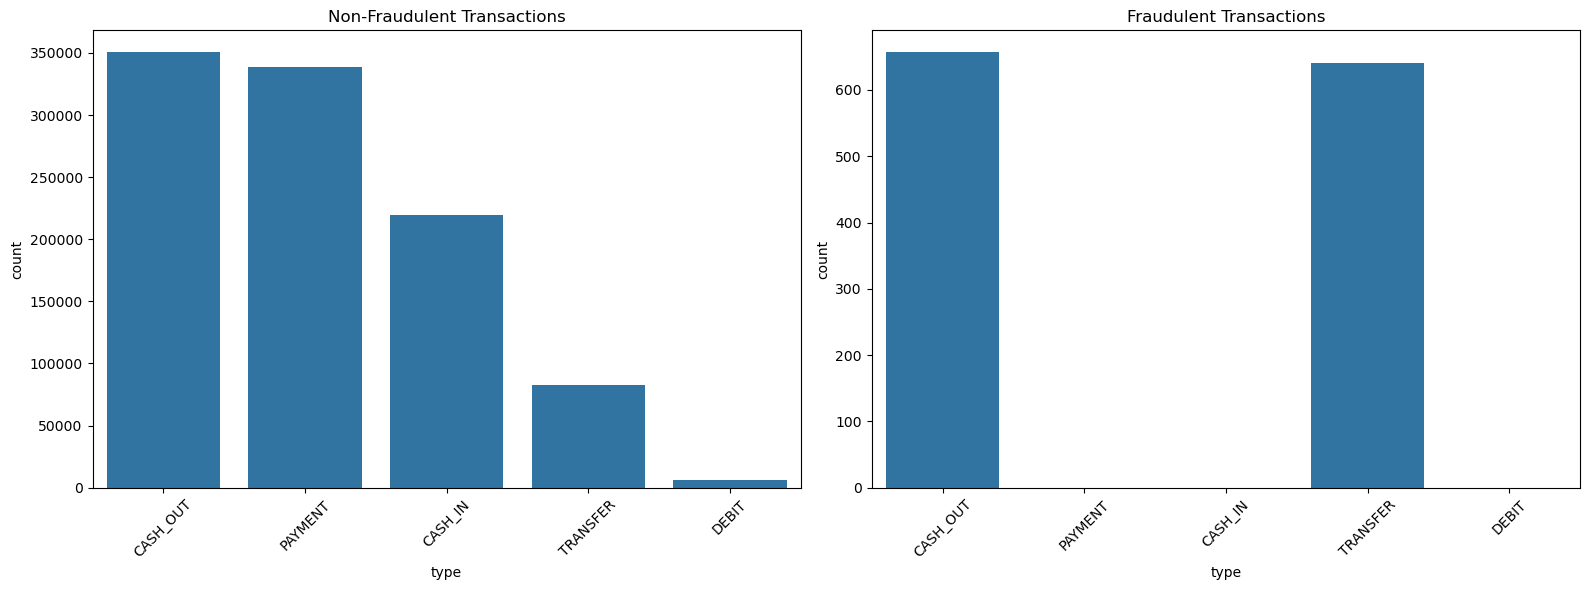

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# non-fraudulent transactions
sns.countplot(
    data=non_fraudulent_transactions,
    x='type',
    order=transactions['type'].value_counts().index,
    ax=axes[0]
)
axes[0].set_title('Non-Fraudulent Transactions')
axes[0].tick_params(axis='x', rotation=45)

# fraudulent transactions
sns.countplot(
    data=fraudulent_transactions,
    x='type',
    order=transactions['type'].value_counts().index,
    ax=axes[1]
)
axes[1].set_title('Fraudulent Transactions')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Fraudulent transactions occur **exclusively** in the `CASH_OUT` and `TRANSFER` transaction types. No fraud was detected in `PAYMENT`, `CASH_IN`, or `DEBIT` transactions.

The `isFlaggedFraud` feature is generated by a naive rule that flags transactions over 200,000 as fraudulent. Based on the EDA, this approach fails to detect the vast majority of actual fraud cases and does not contribute any meaningful predictive value. Since it does not align with the target variable `isFraud` and only increases memory usage, it should be removed from the dataset before modeling.

### Numerical Feature Inspection

In [21]:
numerical_cols = [
    'amount',
    'oldbalanceOrg',
    'newbalanceOrig',
    'oldbalanceDest', 
    'newbalanceDest'
]
print(f'Summary statistic on numerical features:')
display(transactions[numerical_cols].describe())

Summary statistic on numerical features:


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
mean,1.796208e+05,8.351184e+05,8.565104e+05,1.102856e+06,1.227859e+06
std,6.076181e+05,2.892918e+06,2.928896e+06,3.464915e+06,3.752688e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.336939e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.443500e+04,1.411000e+04,0.000000e+00,1.331849e+05,2.148652e+05
75%,2.083404e+05,1.073804e+05,1.446566e+05,9.430209e+05,1.110702e+06
max,9.244552e+07,3.958504e+07,3.893942e+07,3.555534e+08,3.560159e+08


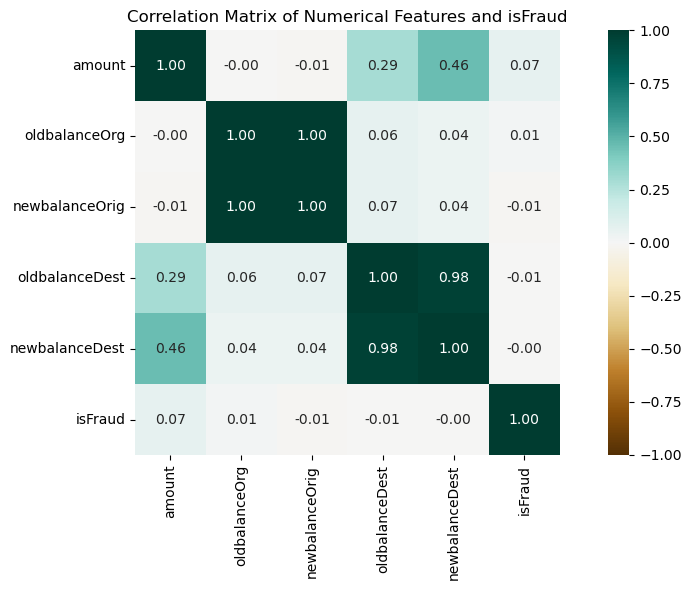

In [22]:
correlation = transactions[numerical_cols + ['isFraud']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(
    data=correlation,
    vmin=-1,
    vmax=1,
    annot=True,
    cmap='BrBG',
    fmt=".2f",
    square=True,
)

plt.title('Correlation Matrix of Numerical Features and isFraud')
plt.tight_layout()
plt.show()

In [23]:
def stats(df,col):
    stats = (
            df
            .groupby('type')[col]
            .describe()
            .reset_index()
        )
    print(f'Summary statistic by transaction type on "{col}" feature:')
    display(stats)

In [24]:
stats(transactions, 'amount')

Summary statistic by transaction type on "amount" feature:


,type,count,mean,std,min,25%,50%,75%,max
0,CASH_IN,219955.0,168928.914668,1.267864e+05,0.43,70092.845,142942.990,240085.0800,1609288.13
1,CASH_OUT,351360.0,175584.659320,1.703743e+05,0.00,72382.815,146209.915,245881.7625,10000000.00
2,DEBIT,6417.0,5445.890813,1.302416e+04,5.24,1530.240,3099.530,5423.2500,389762.68
3,PAYMENT,338573.0,13055.592085,1.256291e+04,0.03,4377.100,9481.670,17565.5600,230549.18
4,TRANSFER,83695.0,911827.155179,1.896175e+06,2.60,217105.800,487883.710,978027.6650,92445516.64


In [25]:
amount_summary = (
    transactions
    .groupby(['type', 'isFraud'])['amount']
    .agg(['count', 'mean', 'median', 'min', 'max', 'std'])
    .reset_index()
    .sort_values(by=['type', 'isFraud'])
)

display(amount_summary)

,type,isFraud,count,mean,median,min,max,std
0,CASH_IN,0,219955,1.689289e+05,142942.99,0.43,1609288.13,1.267864e+05
1,CASH_OUT,0,350703,1.734277e+05,146085.00,1.74,2393198.44,1.310352e+05
2,CASH_OUT,1,657,1.326971e+06,374178.28,0.00,10000000.00,2.244505e+06
3,DEBIT,0,6417,5.445891e+03,3099.53,5.24,389762.68,1.302416e+04
4,PAYMENT,0,338573,1.305559e+04,9481.67,0.03,230549.18,1.256291e+04
5,TRANSFER,0,83055,9.081874e+05,488022.88,2.60,92445516.64,1.892640e+06
6,TRANSFER,1,640,1.384176e+06,454774.80,164.00,10000000.00,2.262100e+06


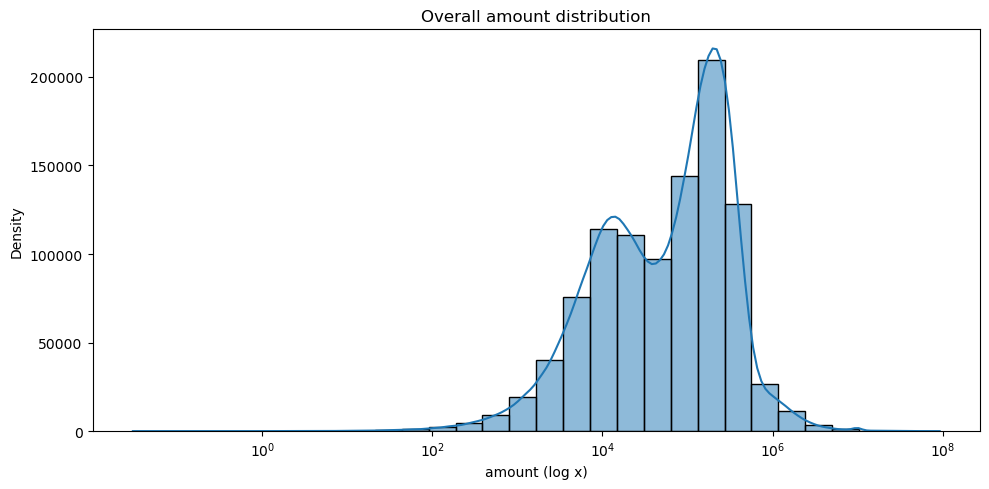

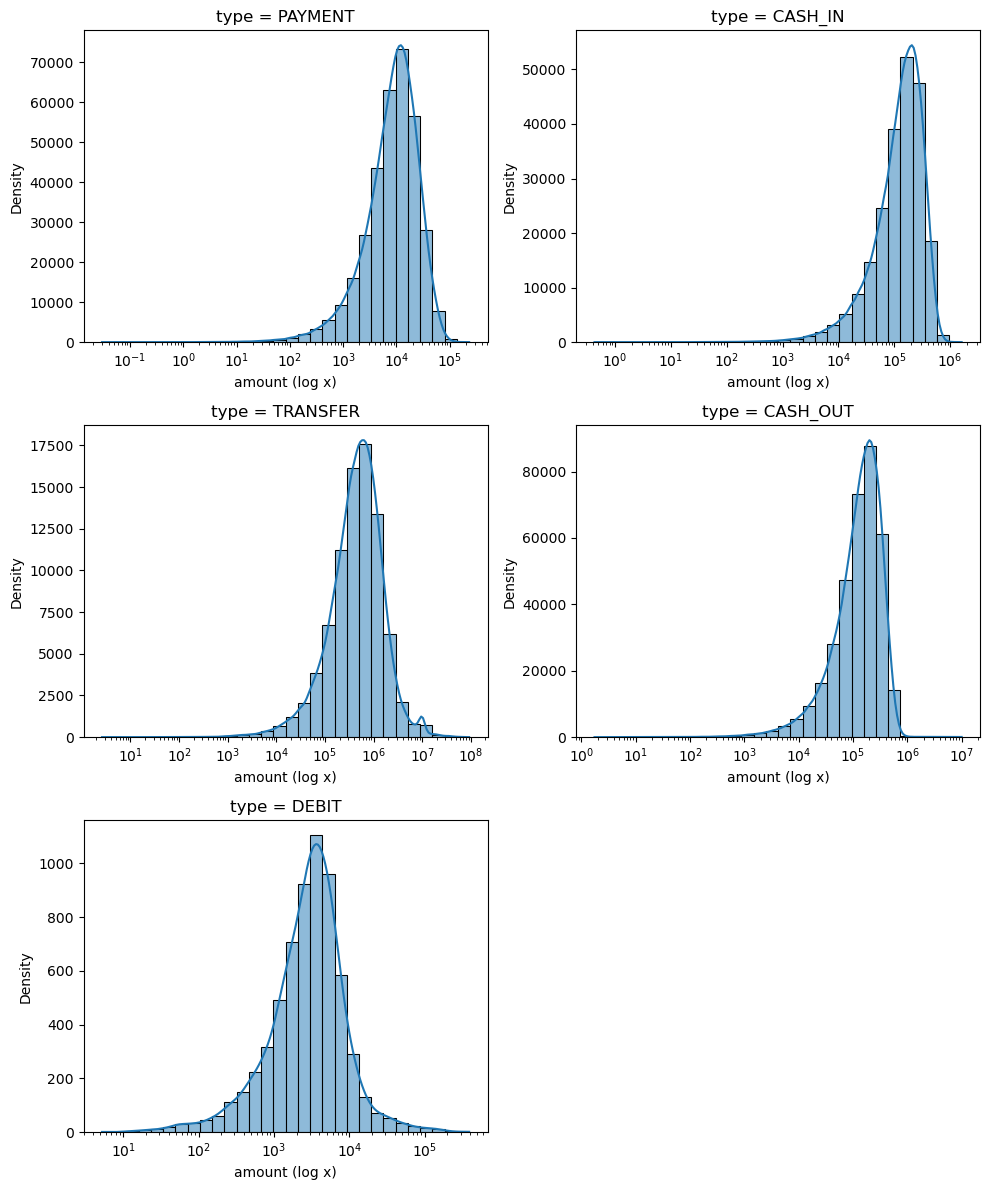

In [26]:
amount_nonzero = transactions['amount'][transactions['amount'] > 0]

# overall distribution
_, ax = plt.subplots(figsize=(10, 5))
sns.histplot(amount_nonzero, bins=30, kde=True, log_scale=(True, False), ax=ax)
ax.set_title('Overall amount distribution')
ax.set_xlabel('amount (log x)')
ax.set_ylabel('Density')
plt.tight_layout()
plt.show()

# per type
types = transactions['type'].unique()
cols = 2
rows = math.ceil(len(types) / cols)
_, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for ax, t in zip(axes, types):
    subset = transactions[(transactions['type'] == t) & (transactions['amount'] > 0)]
    sns.histplot(subset['amount'], bins=30, kde=True, log_scale=(True, False), ax=ax)
    ax.set_title(f"type = {t}")
    ax.set_xlabel('amount (log x)')
    ax.set_ylabel('Density')

# hide unused subplots
for ax in axes[len(types):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

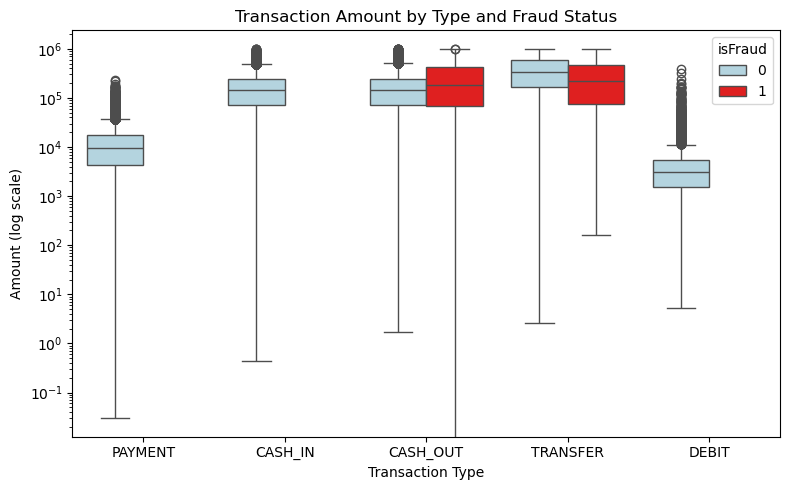

In [27]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=transactions[transactions['amount'] < 1e6],  # exclude extreme outliers
    x='type',
    y='amount',
    hue='isFraud',
    palette={0: 'lightblue', 1: 'red'}
)
plt.yscale('log')
plt.title('Transaction Amount by Type and Fraud Status')
plt.ylabel('Amount (log scale)')
plt.xlabel('Transaction Type')
plt.tight_layout()
plt.show()

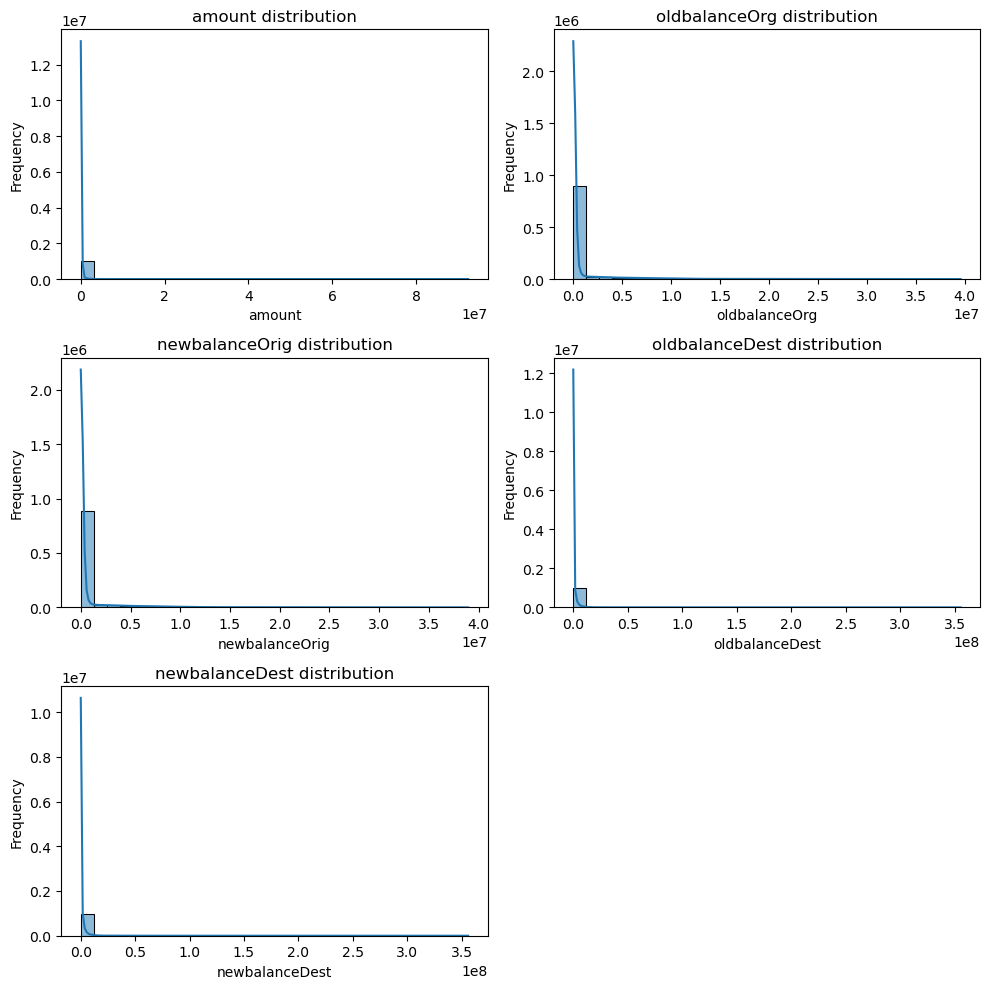

In [28]:
plt.figure(figsize=(10, 10))

for i, col in enumerate(numerical_cols):
    plt.subplot(3, 2, i + 1)
    data = transactions[col] 
    sns.histplot(data, bins=30, kde=True)
    plt.title(f'{col} distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

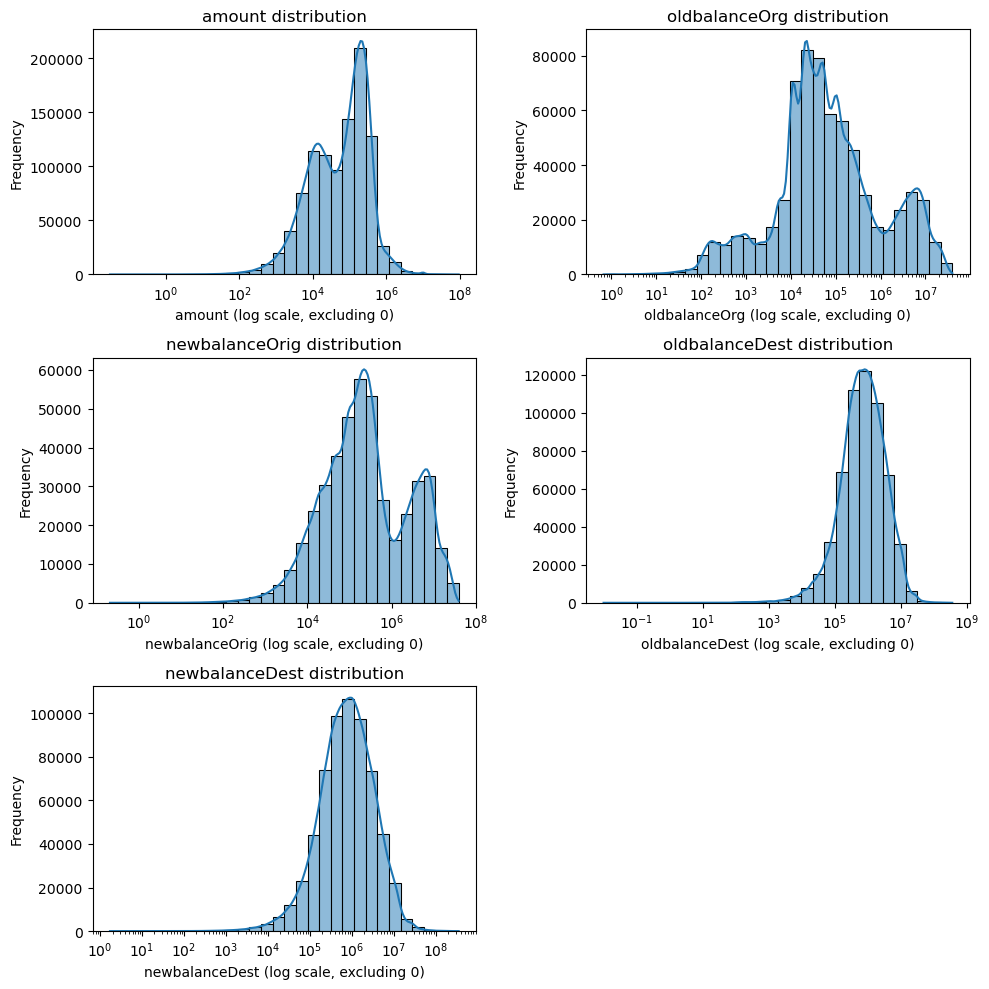

In [29]:
plt.figure(figsize=(10, 10))

for i, col in enumerate(numerical_cols):
    plt.subplot(3, 2, i + 1)
    data = transactions[col][transactions[col] > 0]  
    sns.histplot(data, bins=30, kde=True, log_scale=(True, False))  
    plt.title(f'{col} distribution')
    plt.xlabel(f'{col} (log scale, excluding 0)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

/var/folders/xn/q5_c27vd0dg24dy1lqs64p7c0000gn/T/ipykernel_43201/942206441.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


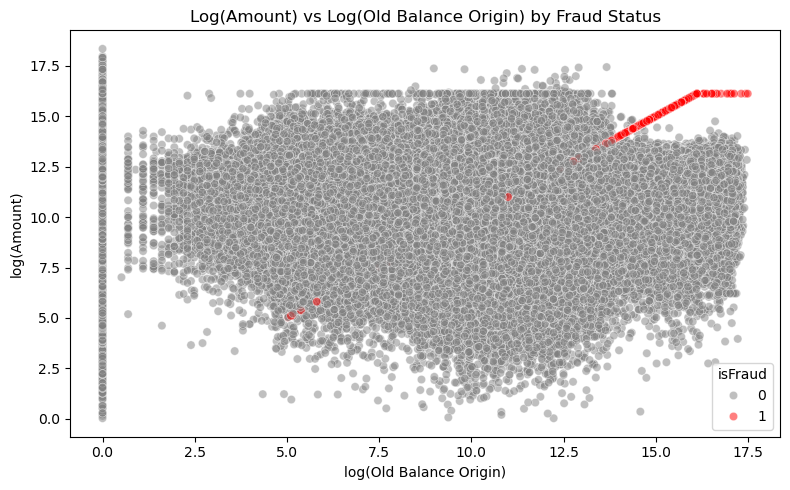

In [40]:
df = transactions.copy()
df = df[df['amount'] > 0]
df['log_amount'] = np.log1p(df['amount'])
df['log_oldbalanceOrg'] = np.log1p(df['oldbalanceOrg'])

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x='log_oldbalanceOrg',
    y='log_amount',
    hue='isFraud',
    alpha=0.5,
    palette={0: 'gray', 1: 'red'}
)
plt.title('Log(Amount) vs Log(Old Balance Origin) by Fraud Status')
plt.xlabel('log(Old Balance Origin)')
plt.ylabel('log(Amount)')
plt.legend(title='isFraud')
plt.tight_layout()
plt.show()

/var/folders/xn/q5_c27vd0dg24dy1lqs64p7c0000gn/T/ipykernel_43201/2812793734.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


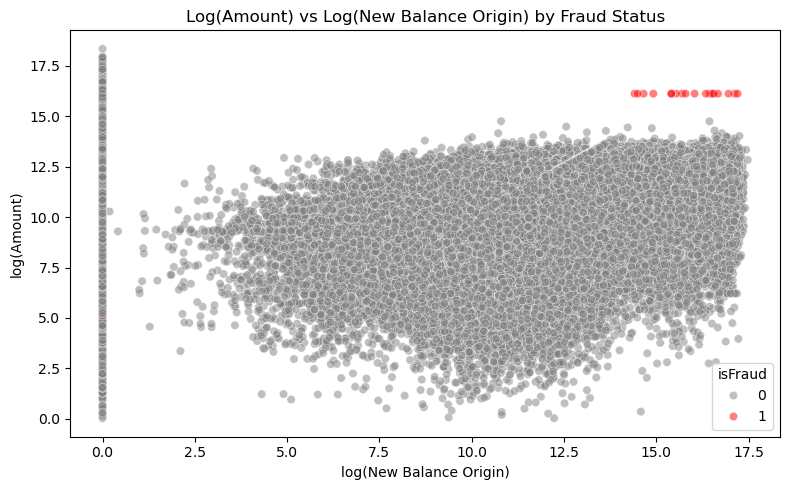

In [39]:
df['log_newbalanceOrig'] = np.log1p(df['newbalanceOrig'])

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x='log_newbalanceOrig',
    y='log_amount',
    hue='isFraud',
    alpha=0.5,
    palette={0: 'gray', 1: 'red'}
)
plt.title('Log(Amount) vs Log(New Balance Origin) by Fraud Status')
plt.xlabel('log(New Balance Origin)')
plt.ylabel('log(Amount)')
plt.legend(title='isFraud')
plt.tight_layout()
plt.show()

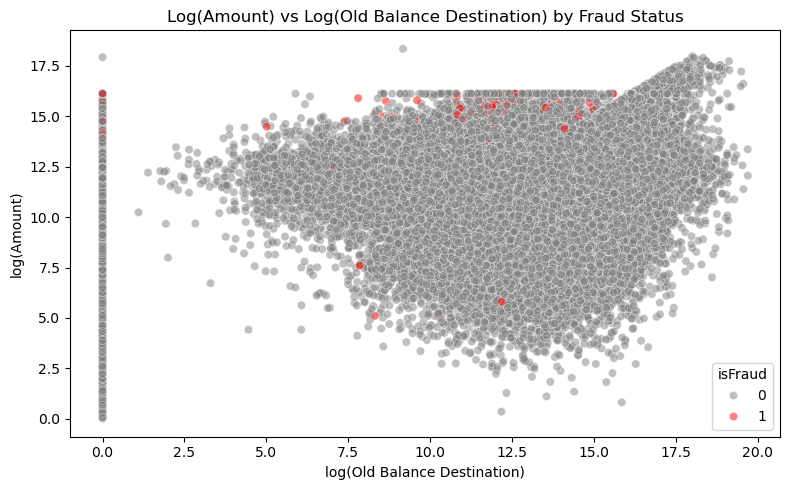

In [38]:
df['log_oldbalanceDest'] = np.log1p(df['oldbalanceDest'])

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x='log_oldbalanceDest',
    y='log_amount',
    hue='isFraud',
    alpha=0.5,
    palette={0: 'gray', 1: 'red'}
)
plt.title('Log(Amount) vs Log(Old Balance Destination) by Fraud Status')
plt.xlabel('log(Old Balance Destination)')
plt.ylabel('log(Amount)')
plt.legend(title='isFraud')
plt.tight_layout()
plt.show()

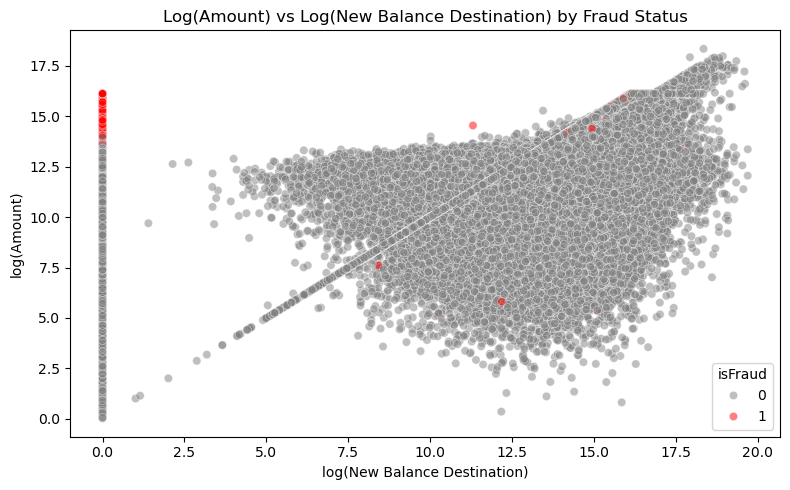

In [37]:
df['log_newbalanceDest'] = np.log1p(df['newbalanceDest'])

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,  
    x='log_newbalanceDest',
    y='log_amount',
    hue='isFraud',
    alpha=0.5,
    palette={0: 'gray', 1: 'red'}
)
plt.title('Log(Amount) vs Log(New Balance Destination) by Fraud Status')
plt.xlabel('log(New Balance Destination)')
plt.ylabel('log(Amount)')
plt.legend(title='isFraud')
plt.tight_layout()
plt.show()

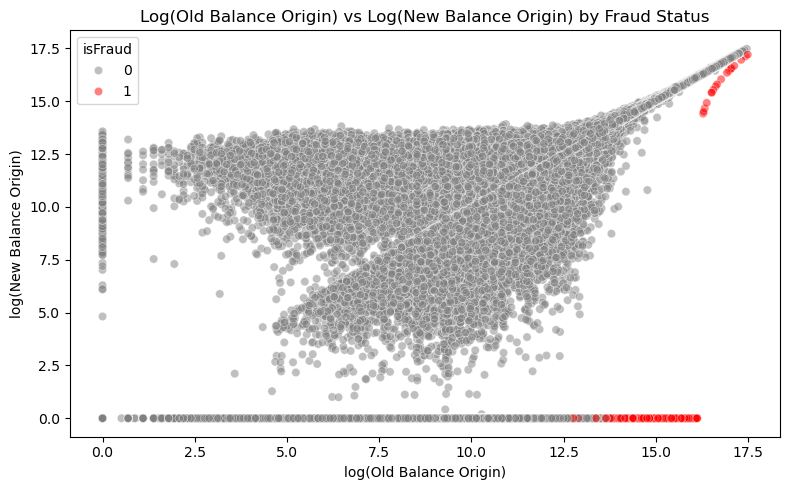

In [36]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,  
    x='log_oldbalanceOrg',
    y='log_newbalanceOrig',
    hue='isFraud',
    alpha=0.5,
    palette={0: 'gray', 1: 'red'}
)
plt.title('Log(Old Balance Origin) vs Log(New Balance Origin) by Fraud Status')
plt.xlabel('log(Old Balance Origin)')
plt.ylabel('log(New Balance Origin)')
plt.legend(title='isFraud')
plt.tight_layout()
plt.show()

In [41]:
conf_matrix = pd.crosstab(
    transactions['isFraud'],
    transactions['isFlaggedFraud'],
    rownames=['Actual (isFraud)'],
    colnames=['Flagged (isFlaggedFraud)']
)

display(conf_matrix)

Flagged (isFlaggedFraud),0,1
Actual (isFraud),,
0,998703,0
1,1296,1


In [42]:
TP = conf_matrix.loc[1, 1] if (1 in conf_matrix.index and 1 in conf_matrix.columns) else 0
FP = conf_matrix.loc[0, 1] if (0 in conf_matrix.index and 1 in conf_matrix.columns) else 0
FN = conf_matrix.loc[1, 0] if (1 in conf_matrix.index and 0 in conf_matrix.columns) else 0
TN = conf_matrix.loc[0, 0] if (0 in conf_matrix.index and 0 in conf_matrix.columns) else 0

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1 Score:  {f1:.4f}')

Precision: 1.0000
Recall:    0.0008
F1 Score:  0.0015


## Reflections

Answer each question based on the visualizations that you've generated.

Remember, you must justify your answers with proof.

### Q1

Take a closer look at the numeric features in your dataset. How are these values distributed and what might this tell you about how most transactions behave compared to a few **rare** ones?

**Hint**: Consider using visualizations that highlight frequency across value ranges.

Numeric fields in the dataset (`amount`, `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, and `newbalanceDest`) exhibit strong right skew. This is characterized by a large concentration of transactions at low values, with a long tail of rare, high-value outliers.

This distribution suggests that typical transactions are relatively small. For modeling and visualization, applying log transformations may help mitigate the skew and improve interpretability.

### Q2

When comparing different numerical features against one another, do any interesting patterns emerge for transactions marked as fraudulent? Are there particular regions or ranges where these transactions seem to concentrate?

**Hint**: Try comparing two numeric features at a time while distinguishing between fraud and non-fraud. Use visual cues to spot clusters or anomalies.

Fraud happens only in `TRANSFER` and `CASH_OUT` transactions. These are usually high-value and leave the origin account with a zero balance.

In `amount` vs `oldbalanceOrg`, fraud points follow a diagonal, meaning the full balance was transferred. This pattern is not common in non-fraud cases.

In `oldbalanceOrg` vs `newbalanceOrig`, fraud points cluster at `newbalanceOrig = 0`, showing the account was emptied. Non-fraud cases show more variety.

Overall, fraud often means draining the full account balance, while non-fraud transactions are smaller and more varied.

### Q3

How do types of transaction relate to the typical amounts involved? Are some types of transactions consistently larger or smaller than others?

**Hint**: Break the dataset down by transaction type and compare summary statistics.

`TRANSFER` transactions have the highest typical amounts, with a median around 488K and a maximum over 92M. These transactions show high variability and are used for large transfers.

`CASH_OUT` and `CASH_IN` follow, both with medians around 142K–146K. They are likely related to business or high-value personal activity.

`PAYMENT` and `DEBIT` transactions are much smaller, with medians of about 9.4K and 3K, suggesting they are common, low-value consumer transactions.

Balance features follow this pattern too—high-value types like `TRANSFER`, `CASH_OUT`, and `CASH_IN` show larger balances. `PAYMENT` transactions often show zero destination balances, hinting at internal transfers.

Overall, transaction types vary widely in scale. `TRANSFER` is the most high-value and variable, while `PAYMENT` and `DEBIT` are smaller and likely low-risk.

### Q4

Do transaction amounts vary when you compare fraudulent and non-fraudulent transactions across different transaction types? What patterns emerge when you look at both fraud status and transaction type together?

**Hint**:  Try summarizing average transaction amounts by both fraud label and transaction type to compare across categories.

**Fraud occurs only in TRANSFER and CASH_OUT types**.
- In both cases, **fraudulent transactions have significantly higher average amounts** than non-fraudulent ones:
  - **CASH_OUT**:
    - Fraud mean: \$1.33M vs Non-fraud mean: \$173K
  - **TRANSFER**:
    - Fraud mean: \$1.38M vs Non-fraud mean: \$908K

- **Median values** also follow this trend, though the difference is smaller:
  - Fraud medians in both types still exceed 370K.

- Other types (**PAYMENT, DEBIT, CASH_IN**) show **no fraud**, and have much smaller amounts (median: 3K–143K).

Fraudulent transactions are concentrated in **high-value CASH_OUT and TRANSFER types**, and tend to involve **much larger amounts** than typical transactions of the same type.

## Q5

Consider how well the system's built-in fraud flag (`isFlaggedFraud`) aligns with actual fraudulent activity. Are there mismatches? What does this tell you about the system's current performance?

**Hint**: Try organizing the data in a way that shows how often flagged transactions are truly fraudulent and how often fraud goes unflagged.

Answer here

- **Confusion Matrix**:

| Actual (isFraud) | Flagged = 0 | Flagged = 1 |
|------------------|-------------|-------------|
| 0 (not fraud)    | 998,703     | 0           |
| 1 (fraud)        | 1,296       | 1           |

- **Precision**: 1.00  
  → The one flagged transaction was indeed fraud.

- **Recall**: 0.0008  
  → Out of 1,297 actual frauds, the system flagged **only one**.

- **F1 Score**: 0.0015  
  → Very poor balance between precision and recall.

The current rule-based flagging system is extremely **conservative**—it avoids false positives entirely but **fails to detect nearly all frauds**. A machine learning–based model is needed to improve recall while maintaining precision.